CANADA MISSION NEWS ARTICLES

https://www.international.gc.ca/world-monde/international_relations-relations_internationales/un-onu/news-nouvelles/index.aspx?lang=eng

STEP 1 - SCRAPE DATA FROM WEBSITE

In [2]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

In [10]:
URL = "https://www.international.gc.ca/world-monde/international_relations-relations_internationales/un-onu/news-nouvelles/index.aspx?lang=eng"
CUTOFF_DATE = datetime(2018, 1, 1)

response = requests.get(URL)
soup = BeautifulSoup(response.content, "html.parser")

articles = []

for li in soup.select("ul.feeds-cont > li"):
    a_tag = li.find("a", href=True)
    time_tag = li.find("time")

    if a_tag and time_tag:
        title = a_tag.text.strip()
        href = a_tag['href'].strip()
        url = href if href.startswith("http") else "https://www.international.gc.ca" + href
        date_str = time_tag.text.strip()

        try:
            date = datetime.strptime(date_str, "%Y-%m-%d")
        except ValueError:
            continue

        if date >= CUTOFF_DATE:
            articles.append({
                "title": title,
                "url": url,
                "date": date.strftime("%Y-%m-%d")
            })

# Save to DataFrame
df = pd.DataFrame(articles)

In [12]:
def extract_clean_paragraphs(paragraphs):
    cleaned = []
    for p in paragraphs:
        # If <p> only contains a single <strong> or <em>, skip it
        children = list(p.children)
        if len(children) == 1 and (p.find("strong") or p.find("em")):
            continue
        text = p.get_text(strip=True)
        if text and len(text) > 30:  # filter out short/boilerplate stuff
            cleaned.append(text)
    return "\n\n".join(cleaned)

def extract_article_content(url):
    try:
        res = requests.get(url, timeout=10)
        soup = BeautifulSoup(res.content, "html.parser")
        main = soup.find("main")
        if not main:
            return ""
        paragraphs = main.find_all("p")
        return extract_clean_paragraphs(paragraphs)
    except Exception as e:
        print(f"❌ Failed to scrape {url}: {e}")
        return ""

In [13]:
# Add new "content" column to the existing DataFrame
df["text"] = df["url"].apply(extract_article_content)

excel_path = "canada_mission_statements.xlsx"
sheet_name = 'raw'

df.to_excel(excel_path, sheet_name=sheet_name, index=False)
print(f"📄 Articles saved to {excel_path}")

📄 Articles saved to canada_mission_statements.xlsx


STEP 2 - DATA ANALYSIS

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    'minister', 'honourable', 'security', 'council', 'foreign', 'united', 'nations',
    'canada', 'operations','conference', 'international', 'global', 'today', 'world',
    'public', 'assembly', 'states', 'continue', 'permanent', 'day', 'help', 'recognized',
    'live','strengthen', 'country', 'work', 'need', 'new', 'gc', 'chrystia', 'affairs',
    'including', 'ensure', '2018', 'media', 'session', 'new', 'york', 'years', 'member',
    'like', 'way', 'important', 'june', 'support', 'general', 'shared', 'million', 'countries',
    'implementation', 'development', 'efforts', 'address', 'canadians', 'announced', 'canadas',
    'office', 'accordance', '27', 'commitment', 'based', 'thank', 'following'
])

texts = df['text']

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

Theme Identification via Natural Language Processing (NLP)

In [77]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['women', 'rights', 'human']
Topic 1:
['russia', 'peace', 'freeland']
Topic 2:
['rights', 'government', 'twitter']
Topic 3:
['humanitarian', 'civilians', 'law']
Topic 4:
['rights', 'human', 'people']


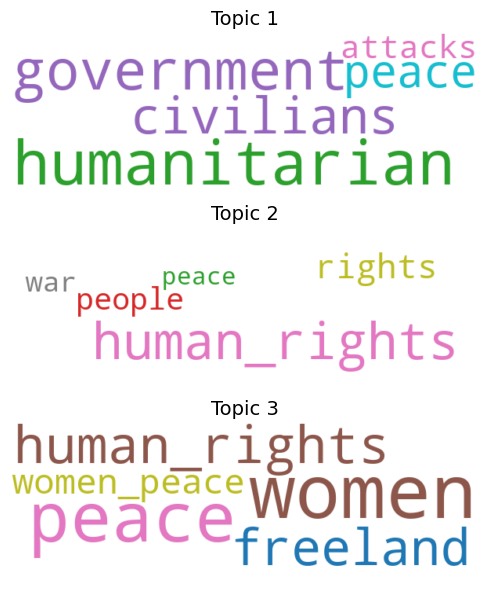

In [78]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [79]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in canada_mission_statements.xlsx


Identifying Themes via Keyword Frequency

In [80]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    12  203  7700media  activities  adam  advance  affairsadam  affected  \
0   0    0          0           2     0        0            0         0   
1   0    0          0           1     0        0            0         0   
2   0    0          0           0     0        0            0         0   
3   0    0          0           0     0        3            0         0   
4   0    0          0           2     0        0            0         0   

   allow  approach  ...  threat  time  twitter  ukraine  use  violations  \
0      1         0  ...       3     2        0        2    0           2   
1      2         0  ...       0     0        0        0    0           0   
2      0         0  ...       0     0        1        0    0           0   
3      0         2  ...       2     2        1        2    0           0   
4      0         0  ...       0     0        0        0    0           0   

   violence  war  women  working  
0         0    2      0        0  


In [81]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
rights             94
human              76
women              63
peace              52
policy             29
russia             29
government         25
humanitarian       25
people             21
conflict           21
violence           20
resolution         19
initiative         18
girls              17
freeland           17
twitter            17
relations          17
law                16
ca                 16
secretaryoffice    15
dtype: int64


In [82]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
rights          1.775967
human           1.416986
women           1.304100
peace           1.123045
humanitarian    1.036563
disabilities    0.924981
persons         0.838648
peacekeeping    0.801138
israel          0.797671
freeland        0.772282
dtype: float64


AI Tagging

In [3]:
excel_path = "canada_mission_news.xlsx"

In [4]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,url,date,text,theme_1,theme_2
0,Canada’s remarks at the UN General Assembly Ve...,https://www.international.gc.ca/world-monde/in...,2024-04-11,When Canada served as Chair of the Angola Sanc...,Weapon Proliferation,Sanction Enforcement
1,"Remarks on behalf of Canada, Australia, New Ze...",https://www.international.gc.ca/world-monde/in...,2024-04-08,"I make this statement on behalf of Australia, ...",Israel - Palestine Conflict,Humanitarian Aid
2,Canada’s explanation of vote on today’s resolu...,https://www.international.gc.ca/news-nouvelles...,2023-10-27,"October 27, 2023 - Ottawa, Ontario - Global Af...",Israel - Palestine Conflict,Humanitarian Aid
3,Minister Joly announces Canada's United Nation...,https://www.canada.ca/en/global-affairs/news/2...,2023-05-09,"Human rights are the foundation of freedom, ju...",Human Rights,Equity and Inclusion
4,Canada’s remarks at UN Human Rights Council Sp...,https://www.international.gc.ca/news-nouvelles...,2021-05-27,“Canada welcomes the ceasefire in Israel and G...,Israel - Palestine Conflict,Human Rights


In [5]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['date'] = pd.to_datetime(tagged['date'], errors='coerce')
tagged['year'] = tagged['date'].dt.year

tagged.head()

,title,url,date,text,theme,year
0,Canada’s remarks at the UN General Assembly Ve...,https://www.international.gc.ca/world-monde/in...,2024-04-11,When Canada served as Chair of the Angola Sanc...,Weapon Proliferation,2024
1,"Remarks on behalf of Canada, Australia, New Ze...",https://www.international.gc.ca/world-monde/in...,2024-04-08,"I make this statement on behalf of Australia, ...",Israel - Palestine Conflict,2024
2,Canada’s explanation of vote on today’s resolu...,https://www.international.gc.ca/news-nouvelles...,2023-10-27,"October 27, 2023 - Ottawa, Ontario - Global Af...",Israel - Palestine Conflict,2023
3,Minister Joly announces Canada's United Nation...,https://www.canada.ca/en/global-affairs/news/2...,2023-05-09,"Human rights are the foundation of freedom, ju...",Human Rights,2023
4,Canada’s remarks at UN Human Rights Council Sp...,https://www.international.gc.ca/news-nouvelles...,2021-05-27,“Canada welcomes the ceasefire in Israel and G...,Israel - Palestine Conflict,2021


In [6]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in canada_mission_news.xlsx
